In [20]:
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import mlab
import pandas as pd
#import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
#import scipy.optimize as opt
#import itertools

In [2]:
# Import data
data1 = pd.read_csv('./Sunrise_Blvd_MVDS_data_NoIncidents.csv', sep=',')

#Filtering detectors
selected_detectors = data1['DETECTOR_ID'].isin([11, 15])
data1 = data1[selected_detectors]

In [3]:
#CLeaning null values and outliers
data = data1.dropna()
data = data[(data.TOTAL_VOL <= 800)]

# Creating column with the volume per lane
data['vol_lane'] = (data['TOTAL_VOL'] / 3) * 4
data['density'] = (5280*data['AVG_OCC']) / (100*(15+6))
data['TIMESTAMP'] = pd.to_datetime(data['DATE_TIME'])
data2 = data.drop(['DATE_TIME', 'DETECT_TIME', 'DETECT_DATE', 'TOTAL_VOL', 'AVG_TT', 'AVG_OCC'], axis = 1)
dir_num = {'EB': 1,'WB': 2}
data2['DIR_NUM'] = data2['DIRECTION']
data2.DIR_NUM = [dir_num[item] for item in data2.DIR_NUM]
data2['DAY_WEEK'] = data2['TIMESTAMP'].dt.dayofweek
data2['TIME_DAY'] = data2['TIMESTAMP'].dt.time

data2['hours'] = data2['TIMESTAMP'].dt.hour
data2['minutes'] = data2['TIMESTAMP'].dt.minute
data2['min_dec'] = data2['minutes'] / 60
data2['TIME_DEC'] = data2['hours'] + data2['min_dec']
data2 = data2.drop(['hours', 'minutes', 'min_dec'], axis = 1)

data2 = data2[['TIMESTAMP', 'DAY_WEEK', 'TIME_DAY', 'TIME_DEC', 'DIR_NUM','DIRECTION','DETECTOR_ID',
               'density', 'AVG_SPEED', 'vol_lane']]

In [25]:
# creating a data frame for each direction
data_selected = data2[(data2.DIRECTION == 'WB')]

In [26]:
# Separating fata by detector
# Eastbound
data_selected = data_selected[(data_selected.DETECTOR_ID == 11)]

In [27]:
data_selected[:2]

,TIMESTAMP,DAY_WEEK,TIME_DAY,TIME_DEC,DIR_NUM,DIRECTION,DETECTOR_ID,density,AVG_SPEED,vol_lane
28476,2015-06-04 07:00:00,3,07:00:00,7.00,2,WB,11,12.571429,39.000000,404.000000
28477,2015-06-04 07:15:00,3,07:15:00,7.25,2,WB,11,14.247619,38.333333,454.666667


## Clustering

In [28]:

features = ['AVG_SPEED', 'vol_lane', 'density']
select_EB11_std = stats.zscore(data_selected[features])


In [29]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_selected[features])
    Sum_of_squared_distances.append(km.inertia_)

<IPython.core.display.Javascript object>


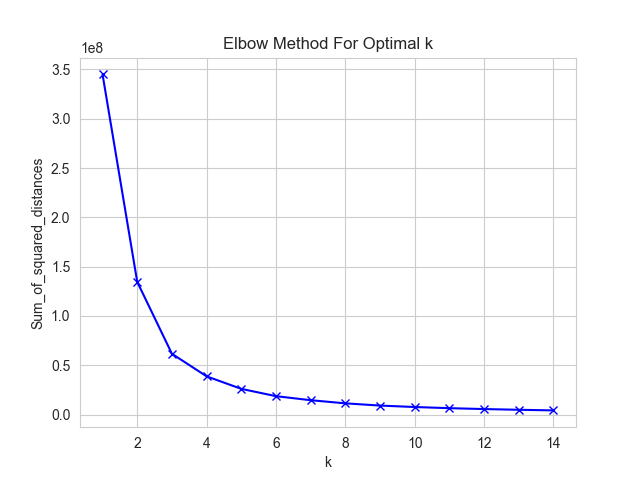

In [30]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [31]:
kmeans_avg = KMeans(n_clusters=3, random_state=0).fit(select_EB11_std)
labels = kmeans_avg.labels_
kmeans_avg.cluster_centers_

select_EB11['clusters'] = labels
features.extend(['clusters'])
select_EB11[features].groupby(['clusters']).mean()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,AVG_SPEED,vol_lane,density
clusters,,,
0,40.813040,373.876059,10.842550
1,36.192052,632.978811,22.239805
2,28.976397,765.135155,41.203597


In [33]:
sns.lmplot('vol_lane', 'AVG_SPEED', data=data_selected, fit_reg=False, height=4, aspect=1.2, hue="clusters", palette="Set1", 
           #markers=['o', '.', '+', '^']) 
           scatter_kws={"marker": "D", "s": 5})

sns.set_style("whitegrid")
plt.title('Clusters volume vs speed')
plt.xlabel('volume, q')
plt.ylabel('speed, v')

KeyError: "['clusters'] not in index"